# Deep Learning

In [1]:
# Boilerplate to chdir to project root and add projects sources to python path
import os
import sys
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    sys.path.append(os.path.abspath('.'))

# Prepare the dataset
import biosignals.prepare as bp
# if not bp.has_prepared('rand'):
#     bp.prepare_rand()

if not bp.has_prepared('jit'):
    bp.prepare_jit()

Reading clusters
Reading data
Cleaning destination
Preparing splits
Splitting train 0
... adding features
... adding cluster info
... writing to disk
Splitting train 1
... adding features
... adding cluster info
... writing to disk
Splitting test 0
... adding features
... adding cluster info
... writing to disk


2022-12-15 22:15:13.346008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 22:15:13.942899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 22:15:13.942953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-15 22:15:13.942959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Training model cnn-lstm jit


2022-12-15 22:15:15.929728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 22:15:15.946180: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-15 22:15:15.946198: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-15 22:15:15.946496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

(3188, 750, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 748, 256)          24832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 62, 256)          0         
 )                                                               
                                                                 
 dense (Dense)               (None, 62, 128)           32896     
                                                                 
 lstm (LSTM)                 (None, 62, 256)           394240    
                                                                 
 lstm_1 (LSTM)               (None, 62, 256)           525312    
                                                                 
 dense_1 (Dense)             (None, 62, 128)           32896     
                                        

2022-12-15 22:15:51.570273: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 612096000 exceeds 10% of free system memory.


13/13 [==============================] - 8s 478ms/step - loss: 2.6172 - accuracy: 0.5144
Epoch 2/20
13/13 [==============================] - 6s 477ms/step - loss: 2.2808 - accuracy: 0.5950
Epoch 3/20
13/13 [==============================] - 6s 480ms/step - loss: 1.9439 - accuracy: 0.7108
Epoch 4/20
13/13 [==============================] - 6s 483ms/step - loss: 1.7131 - accuracy: 0.7365
Epoch 5/20
13/13 [==============================] - 6s 496ms/step - loss: 1.4567 - accuracy: 0.7999
Epoch 6/20
13/13 [==============================] - 7s 506ms/step - loss: 1.2540 - accuracy: 0.8341
Epoch 7/20
13/13 [==============================] - 7s 519ms/step - loss: 1.0644 - accuracy: 0.8758
Epoch 8/20
13/13 [==============================] - 7s 514ms/step - loss: 0.9139 - accuracy: 0.9050
Epoch 9/20
13/13 [==============================] - 7s 502ms/step - loss: 0.7822 - accuracy: 0.9266
Epoch 10/20
13/13 [==============================] - 7s 502ms/step - loss: 0.6918 - accuracy: 0.9413
Epoch 11/2

INFO:tensorflow:Assets written to: models/cnn-lstm_jit/model.tf/assets


INFO:tensorflow:Assets written to: models/cnn-lstm_jit/model.tf/assets


cnn-lstm_jit train size: 3188
cnn-lstm_jit train tn: 1586
cnn-lstm_jit train fp: 8
cnn-lstm_jit train fn: 26
cnn-lstm_jit train tp: 1568
cnn-lstm_jit train accuracy: 0.9893350062735258
cnn-lstm_jit train precision: 0.9949238578680203
cnn-lstm_jit train recall: 0.9836888331242158
cnn-lstm_jit train f1: 0.9892744479495269
13/13 [==============================] - 0s 33ms/step
cnn-lstm_jit test size: 394
cnn-lstm_jit test tn: 175
cnn-lstm_jit test fp: 22
cnn-lstm_jit test fn: 57
cnn-lstm_jit test tp: 140
cnn-lstm_jit test accuracy: 0.799492385786802
cnn-lstm_jit test precision: 0.8641975308641975
cnn-lstm_jit test recall: 0.7106598984771574
cnn-lstm_jit test f1: 0.7799442896935933


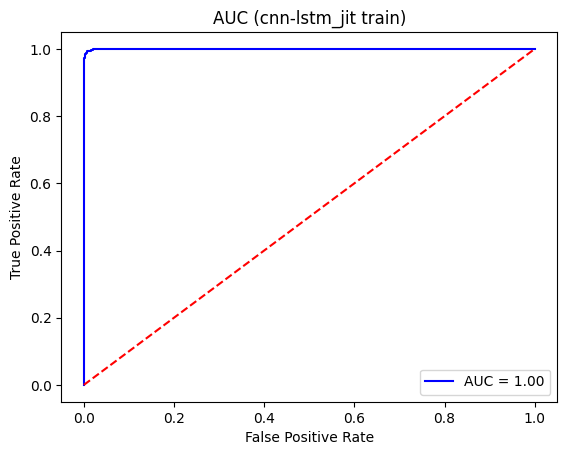

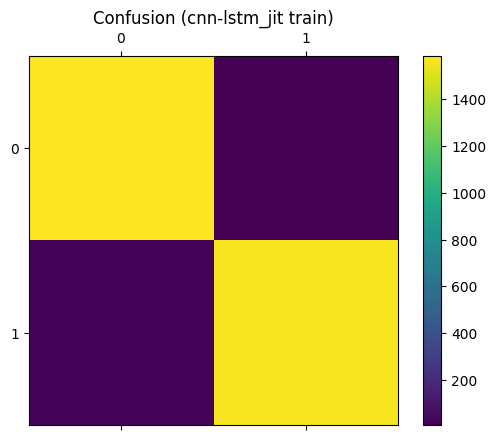

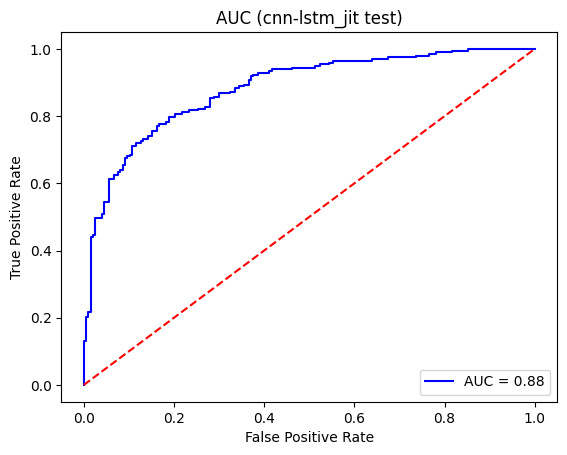

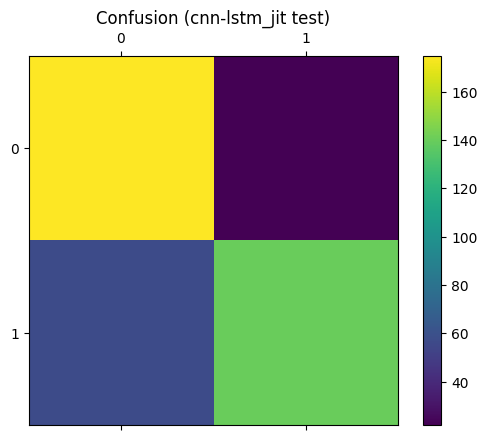

In [1]:
# Boilerplate to chdir to project root and add projects sources to python path
# ---DELETE---
import os
import sys
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    sys.path.append(os.path.abspath('.'))

import biosignals.deep_models as bdeep
# ---DELETE---

bdeep.test_models()

In [1]:
# ---DELETE---
import os
import sys
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    sys.path.append(os.path.abspath('.'))

import biosignals.deep_models as bdeep
# ---DELETE---

bdeep.test_model_load()

2022-12-15 15:24:46.573574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 15:24:47.169080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 15:24:47.169129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-15 15:24:47.169135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

13/13 [==============================] - 1s 39ms/step
cnn-lstm_jit test size: 394
cnn-lstm_jit test tn: 163
cnn-lstm_jit test fp: 34
cnn-lstm_jit test fn: 49
cnn-lstm_jit test tp: 148
cnn-lstm_jit test accuracy: 0.7893401015228426
cnn-lstm_jit test precision: 0.8131868131868132
cnn-lstm_jit test recall: 0.751269035532995
cnn-lstm_jit test f1: 0.7810026385224275


In [ ]:
import biosignals.deep_models as bdeep
# Test deep learning models (LSTM, GRU) so far
bdeep.test_models()

# The rest of this notebook is redundant.

In [ ]:
import biosignals.prepare as bp
import biosignals.evaluation as be
import biosignals.models as bm
from biosignals.split import Role
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Activation
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

In [ ]:
prepared = bp.read_prepared("rand")
print(prepared)

In [ ]:
data = prepared[Role.TRAIN][0].load()
data_val = prepared[Role.VALIDATE][0].load()

In [ ]:
# Eric's Random Forest
bm.test_models()

In [ ]:
from biosignals.models import *
# Hacky way to obtain the clustered data by abusing Eric's work...
data = bp.read_clusters()
model = bm.SkModel(RandomForestClassifier, {}, Strategy.MULTI)
lds = bp.read_prepared('rand')
data = model._load_all(lds[bs.Role.TRAIN], RandomState(42))
data_val = model._load_all(lds[bs.Role.VALIDATE], RandomState(42))
data_test = model._load_all(lds[bs.Role.TEST], RandomState(42))

In [ ]:
print(data[0].shape, data[1].shape, data_val[0].shape, data_val[1].shape, data_test[0].shape, data_test[1].shape)

In [ ]:
train_data = tf.convert_to_tensor(data[0], dtype=tf.float64)
train_labels = tf.convert_to_tensor(data[1], dtype=tf.int32)
print(train_labels.shape, train_data.shape)

val_data = tf.convert_to_tensor(data_val[0], dtype=tf.float64)
val_labels = tf.convert_to_tensor(data_val[1], dtype=tf.int32)

test_data = tf.convert_to_tensor(data_test[0], dtype=tf.float64)
test_labels = tf.convert_to_tensor(data_test[1], dtype=tf.int32)

In [ ]:
#standard scalar
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

#PCA
n_components = 64
pca = PCA(n_components=n_components)
pca.fit(train_data)
train_data_pca = pca.transform(train_data)
val_data_pca = pca.transform(val_data)
test_data_pca = pca.transform(test_data)


# Expand dimensions
train_data_pca = tf.expand_dims(train_data_pca, axis=1)
val_data_pca = tf.expand_dims(val_data_pca, axis=1)
test_data_pca = tf.expand_dims(test_data_pca, axis=1)

train_data_nopca = tf.expand_dims(train_data, axis=1)
val_data_nopca = tf.expand_dims(val_data, axis=1)
test_data_nopca = tf.expand_dims(test_data, axis=1)

print(train_data_pca.shape, val_data_pca.shape, test_data_pca.shape)
print(train_data_nopca.shape, val_data_nopca.shape, test_data_nopca.shape)

In [ ]:
# GRU NO PCA
model_GRU_nopca = bdeep.GRU_Model(train_data_nopca, train_labels, num_epochs=30, batch_size=64)
be.evaluate_model(model_GRU_nopca.predict(val_data_nopca), val_labels)

In [ ]:
# GRU WITH PCA
model_GRU_pca = bdeep.GRU_Model(train_data_pca, train_labels, num_epochs=30, batch_size=64)
be.evaluate_model(model_GRU_pca.predict(val_data_pca), val_labels)

In [ ]:
# LSTM NO PCA
model_LSTM_nopca = bdeep.LSTM_Model(train_data_nopca, train_labels, num_epochs=30, batch_size=64)
be.evaluate_model(model_LSTM_nopca.predict(val_data_nopca), val_labels)

In [ ]:
# LSTM WITH PCA
model_LSTM_pca = bdeep.LSTM_Model(train_data_pca, train_labels, num_epochs=30, batch_size=64)
be.evaluate_model(model_LSTM_pca.predict(val_data_pca), val_labels)

In [ ]:
# Test evaluation
print("GRU - no PCA")
be.evaluate_model(model_GRU_nopca.predict(test_data_nopca), test_labels)
print("GRU - with PCA")
be.evaluate_model(model_GRU_pca.predict(test_data_pca), test_labels)

print("LSTM - no PCA")
be.evaluate_model(model_LSTM_nopca.predict(test_data_nopca), test_labels)
print("LSTM - with PCA")
be.evaluate_model(model_LSTM_pca.predict(test_data_pca), test_labels)

In [ ]:
# Training evaluation (to see if we overfit)
print("GRU - no PCA")
be.evaluate_model(model_GRU_nopca.predict(train_data_nopca), train_labels)
print("GRU - PCA")
be.evaluate_model(model_GRU_pca.predict(train_data_pca), train_labels)
print("LSTM - no PCA")
be.evaluate_model(model_LSTM_nopca.predict(train_data_nopca), train_labels)
print("LSTM - PCA")
be.evaluate_model(model_LSTM_pca.predict(train_data_pca), train_labels)